In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import shap

In [6]:
def load_data(url):
    columns = [
    'Status_of_existing_checking_account', 'Duration_in_month', 'Credit_history',
    'Purpose', 'Credit_amount', 'Savings_account_bonds', 'Present_employment_since',
    'Installment_rate_in_percentage_of_disposable_income', 'Personal_status_and_sex',
    'Other_debtors_guarantors', 'Present_residence_since', 'Property',
    'Age_in_years', 'Other_installment_plans', 'Housing',
    'Number_of_existing_credits_at_this_bank', 'Job',
    'Number_of_people_being_liable_to_provide_maintenance_for',
    'Telephone', 'foreign_worker', 'Target'
]
    df = pd.read_csv(url, sep=' ', header=None, names=columns)
    return df 


def preprocess(df):
    df['Target'] = df['Target'].map({1: 1, 2: 0})
    categorical_cols = df.select_dtypes(include='object').columns
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])
    return df


def macro_add_ons(df):
    german_interest_rate = 3.15  # ECB deposit facility rate (April 2025)
    german_gdp_growth = -0.3  
    df['Interest_Rate'] = german_interest_rate
    df['GDP_Growth'] = german_gdp_growth
    return df


def train(df):
    X = df.drop('Target', axis=1)
    y = df['Target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model = LogisticRegression(max_iter=1000000)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"ROC AUC Score: {roc_auc:.2f}")
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    return model, X, y, X_train_scaled, X_test_scaled, X_test, y_prob


def shap_summary(model, X,X_train_scaled, X_test_scaled, X_test, customer_idx ):
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)
    explainer = shap.Explainer(model, X_train_scaled_df)
    shap_values = explainer(X_test_scaled_df)
    shap.summary_plot(shap_values, X_test, feature_names=X.columns)
    customer_idx = customer_idx
    shap.plots.waterfall(shap_values[customer_idx], max_display=15)
    return shap_values


def loss_variables_summary(y_prob, X_test):
# Source: Bundesbank Risk Reports & ECB IRB parameters
    average_ead = 8200  # average exposure in euros
    average_lgd = 0.4   # average LGD for consumer credit in Germany
    interest_rate = 0.065  # 6.5% realistic APR
    df_results = pd.DataFrame({
    'PD': y_prob,
    'Expected_Loss (€)': y_prob * average_ead * average_lgd,
    'Interest_Income (€)': average_ead * interest_rate
})
    print(f"\nMean Expected Loss: €{df_results['Expected_Loss (€)'].mean():.2f}")
    capital_at_risk = average_ead * average_lgd
    df_results['RAROC'] = (df_results['Interest_Income (€)'] - df_results['Expected_Loss (€)']) / capital_at_risk
    X_test = X_test.reset_index(drop=True)
    monthly_income = X_test['Present_employment_since'] * 15000 / 12
    monthly_installment = X_test['Credit_amount'] * (X_test['Installment_rate_in_percentage_of_disposable_income'] / 100)
    X_test['Estimated_Income (€)'] = monthly_income
    X_test['DSCR'] = monthly_income / (monthly_installment + 1e-5)
    X_test['LTI'] = X_test['Credit_amount'] / (monthly_income * 12 + 1e-5)
    X_test['Collateral_Value'] = X_test['Credit_amount'] * 1.5
    X_test['LTV'] = X_test['Credit_amount'] / (X_test['Collateral_Value'] + 1e-5)
    return df_results, X_test


def assign_moodys_like_rating(pd):
    if pd < 0.01:
        return 'Aaa'
    elif pd < 0.025:
        return 'Aa'
    elif pd < 0.05:
        return 'A'
    elif pd < 0.10:
        return 'Baa'
    elif pd < 0.20:
        return 'Ba'
    elif pd < 0.35:
        return 'B'
    else:
        return 'Caa–C'
    

def risk_band(pd):
    if pd < 0.005: return 'Very Low Risk'
    elif pd < 0.015: return 'Low Risk'
    elif pd < 0.04: return 'Moderate Risk'
    elif pd < 0.10: return 'Elevated Risk'
    elif pd < 0.25: return 'High Risk'
    else: return 'Very High Risk'


def actionable_recommendation_full(row):
    pd = row['PD']
    rating = row['Credit_Rating']
    loss = row['Expected_Loss (€)']
    age = row['Age_in_years']
    credit_amount = row['Credit_amount']
    duration = row['Duration_in_month']
    
    if rating == 'Caa–C':
        if loss > 2000 or pd > 0.5:
            return "❌ Reject: Extremely high risk and loss potential"
        else:
            return "❌ High risk: Only proceed with strong collateral or cosigner"
    elif rating == 'B':
        if duration > 36 and credit_amount > 5000:
            return "⚠️ Caution: Consider reducing loan amount or shortening term"
        else:
            return "⚠️ Medium risk: Require higher interest or additional documentation"
    elif rating in ['Ba', 'Baa']:
        if age < 25 and credit_amount > 4000:
            return "⚠️ Young borrower: Suggest financial counseling or guarantor"
        elif loss > 1000:
            return "⚠️ Review: High expected loss, check affordability"
        else:
            return "✅ Approve with standard monitoring"
    elif rating in ['A', 'Aa', 'Aaa']:
        return "✅ Approve: Low risk, eligible for best interest rates"
    
    elif row['DSCR'] < 1.0:
        return "Reject: Debt cannot be serviced by income"
    elif row['LTI'] > 5.0:
        return "Caution: Loan-to-income exceeds safe limit"
    elif row['RAROC'] < 0.05:
        return "Review: RAROC below acceptable return"
    else:
        return "🔍 Manual review required"
    

def final_output(df_results, X_test):
    df_results['Risk_Band'] = df_results['PD'].apply(risk_band)  
    df_results['Credit_Rating'] = df_results['PD'].apply(assign_moodys_like_rating)
    joined = df_results.join(X_test.reset_index(drop=True))
    joined['Recommendation'] = joined.apply(actionable_recommendation_full, axis=1)
    joined['Young_HighLoan_Flag'] = (X_test['Age_in_years'] < 25) & (X_test['Credit_amount'] > 4000)
    joined['High_Loss_Flag'] = joined['Expected_Loss (€)'] > 2000
    output = X_test.reset_index(drop=True).copy()
    output= joined.copy()
    print("\n--- Sample Output with Credit Insights ---")
    output[['PD', 'Credit_Rating', 'RAROC', 'DSCR', 'LTI', 'Expected_Loss (€)', 'Recommendation',
              'Young_HighLoan_Flag', 'High_Loss_Flag']].head(10)
    return joined, output

    
def summaries(joined):
    print(joined['Credit_Rating'].value_counts())
    print(joined['Recommendation'].value_counts())
    rating_summary = joined.groupby('Credit_Rating')['Expected_Loss (€)'].agg(['count', 'mean'])
    recommendation_summary = joined.groupby('Recommendation')['Recommendation'].agg(['count'])
    young_high_flag = joined.groupby('Young_HighLoan_Flag')['Young_HighLoan_Flag'].agg(['count'])
    high_loss = joined.groupby('High_Loss_Flag')['High_Loss_Flag'].agg(['count'])
    return rating_summary, recommendation_summary, young_high_flag, high_loss


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.54      0.60        46
           1       0.81      0.88      0.85       104

    accuracy                           0.78       150
   macro avg       0.74      0.71      0.73       150
weighted avg       0.77      0.78      0.77       150

ROC AUC Score: 0.85


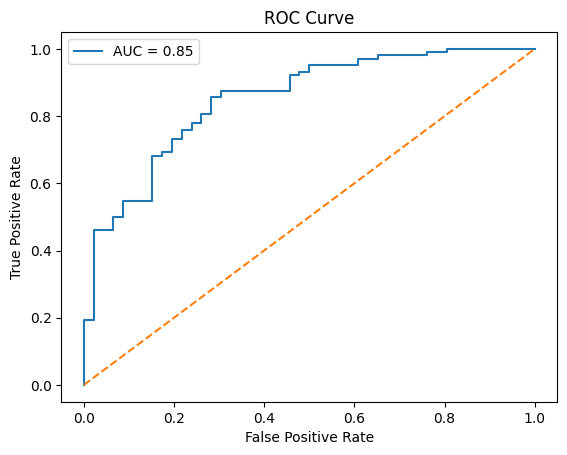

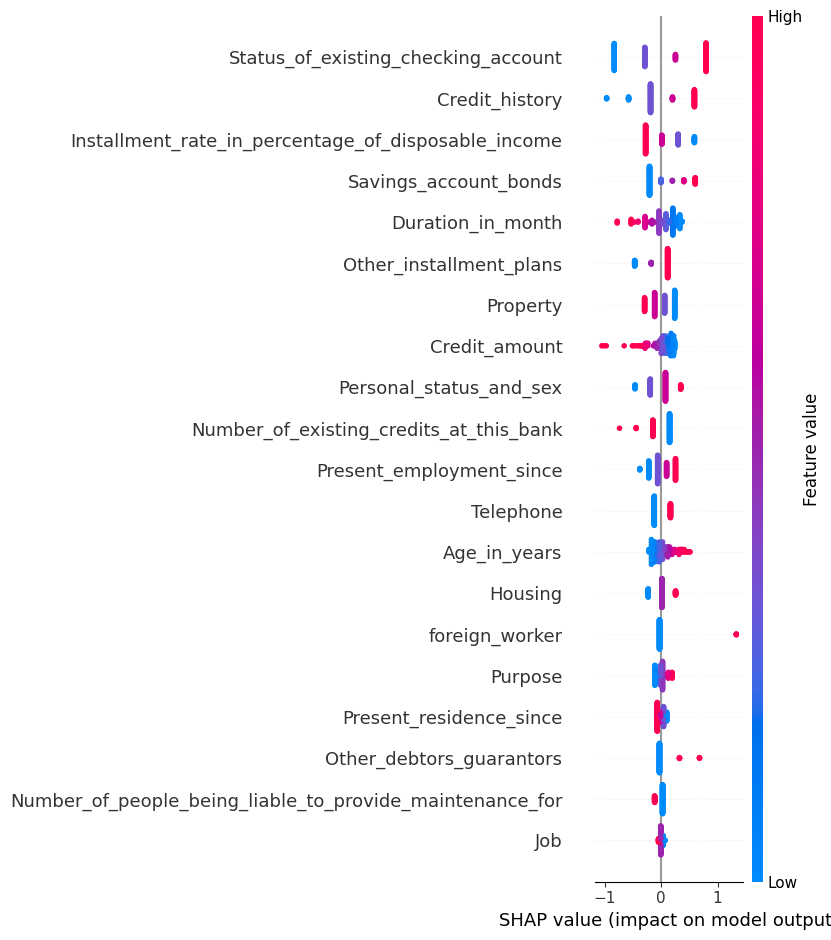

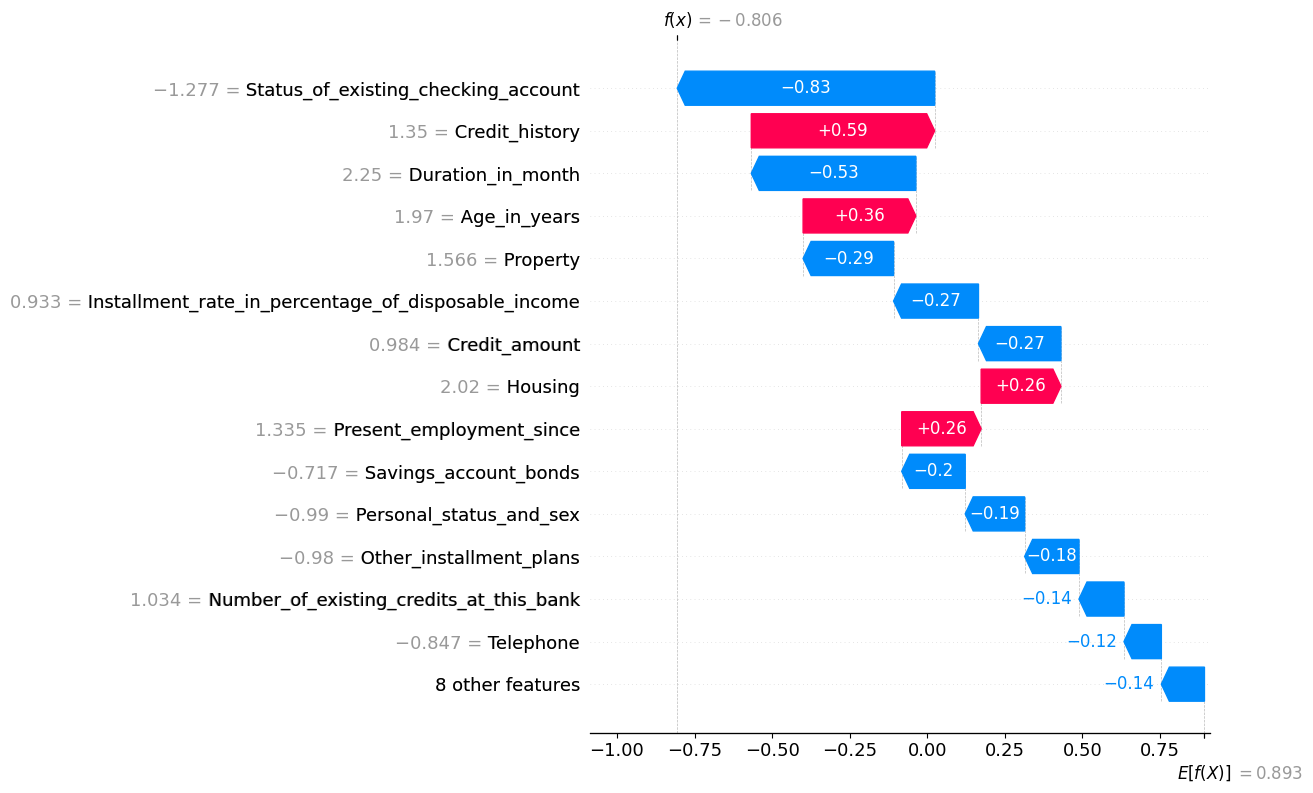


Mean Expected Loss: €2202.21

--- Sample Output with Credit Insights ---
Credit_Rating
Caa–C    131
B         16
Ba         3
Name: count, dtype: int64
Recommendation
❌ Reject: Extremely high risk and loss potential                       113
❌ High risk: Only proceed with strong collateral or cosigner            18
⚠️ Medium risk: Require higher interest or additional documentation     11
⚠️ Caution: Consider reducing loan amount or shortening term             5
✅ Approve with standard monitoring                                       3
Name: count, dtype: int64


In [7]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
df = load_data(url)
df=preprocess(df)
df=macro_add_ons(df)
model, X, y, X_train_scaled, X_test_scaled, X_test, y_prob = train(df)
shap_values=shap_summary(model, X,X_train_scaled, X_test_scaled, X_test, customer_idx=140)
df_results, X_test = loss_variables_summary(y_prob, X_test)
joined, output = final_output(df_results, X_test)
rating_summary, recommendation_summary, young_high_flag, high_loss = summaries(joined)